In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import cf_units as cf
from ctsm_py import utils
import scipy
from scipy import signal,stats
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

%matplotlib inline

## Reading in data

In [3]:
# setting up the file path structure
variables = ['GPP','AR','HR','NEE','NBP','TBOT','SOILLIQ' ]  #TWS not available for CESM1 / CLM4

# --- CESM2 hist (1 ensemble member) ---
Model = 'CESM2 hist1'
pattern = '/glade/collections/cdg/timeseries-cmip6/b.e21.BHIST.f09_g17.CMIP6-historical.001/' \
    'lnd/proc/tseries/month_1/b.e21.BHIST.f09_g17.CMIP6-historical.001.clm2.h0.{var}.185001-201412.nc'

# --- CESM1-LENS hist (1 ensemble member) ---
#Model1 = 'CESM1 LENS1'
#pattern1 = '/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/lnd/proc/tseries/monthly/' \
#    '{var}/b.e11.B20TRC5CNBDRD.f09_g16.001.clm2.h0.{var}.185001-200512.nc'

# --- CLM5 w/ GSWP3 ---
Model1 = 'CLM5 GSWP3'
pattern1 = '/glade/p/cgd/tss/people/oleson/CLM_LAND_ONLY_RELEASE/CLM5/clm50_r270_1deg_GSWP3V1_iso_newpopd_hist/'\
    'lnd/proc/tseries/month_1/clm50_r270_1deg_GSWP3V1_iso_newpopd_hist.clm2.h0.{var}.185001-201412.nc'

file  = [pattern.format(var=var) for var in variables]
file1 = [pattern1.format(var=var) for var in variables]
print(file1[1])

var = variables #redundant, but 'var' is used more later on...
ds = utils.time_set_mid(xr.open_mfdataset(file,combine='by_coords', decode_times=True), 'time')
ds1 = utils.time_set_mid(xr.open_mfdataset(file1,combine='by_coords', decode_times=True), 'time')

print(ds[var[2]].coords)
print(ds1[var[2]].coords)
# since time and levsoi / levgrnd are not the same here, maybe better not to combine datasets

/glade/p/cgd/tss/people/oleson/CLM_LAND_ONLY_RELEASE/CLM5/clm50_r270_1deg_GSWP3V1_iso_newpopd_hist/lnd/proc/tseries/month_1/clm50_r270_1deg_GSWP3V1_iso_newpopd_hist.clm2.h0.AR.185001-201412.nc
Coordinates:
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.25 357.5 358.75
  * lat      (lat) float32 -90.0 -89.057594 -88.11518 ... 89.057594 90.0
  * time     (time) object 1850-01-16 11:45:00 ... 2014-12-16 12:00:00
Coordinates:
  * lat      (lat) float32 -90.0 -89.057594 -88.11518 ... 89.057594 90.0
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.25 357.5 358.75
  * time     (time) object 1850-01-16 11:45:00 ... 2014-12-16 12:00:00


In [4]:
print(var[6])

SOILLIQ


In [5]:
# convert units variables and attributes
for i in range(5):
    ds[var[i]] = ds[var[i]] * 24 * 60 * 60     # g/m2/s --> g/m2/d
    ds[var[i]].attrs['units']= 'gC/m2/d'

ds['TBOT'] = ds.TBOT - 273.15  # K --> C 
ds.TBOT.attrs['units']= 'deg C'

if var[6] == 'SOILLIQ':
    dim_lev = ds[var[6]].dims[1] 
    ds['TOT_SOILLIQ'] = ds.SOILLIQ.sum(dim=dim_lev)
    ds.TOT_SOILLIQ.attrs['units']= ds.SOILLIQ.attrs['units']
    ds.TOT_SOILLIQ.attrs['long_name']= ds.SOILLIQ.attrs['long_name']
else:
    ds['TOT_SOILLIQ'] = ds.TWS

# repeat for second dataset
for i in range(5):
    ds1[var[i]] = ds1[var[i]] * 24 * 60 * 60     # g/m2/s --> g/m2/d
    ds1[var[i]].attrs['units']= 'gC/m2/d'

ds1['TBOT'] = ds1.TBOT - 273.15  # K --> C 
ds1.TBOT.attrs['units']= 'deg C'

if var[6] == 'SOILLIQ':
    dim_lev = ds1[var[6]].dims[1] 
    ds1['TOT_SOILLIQ'] = ds1.SOILLIQ.sum(dim=dim_lev)
    ds1.TOT_SOILLIQ.attrs['units']= ds1.SOILLIQ.attrs['units']
    ds1.TOT_SOILLIQ.attrs['long_name']= ds1.SOILLIQ.attrs['long_name']
else:
    ds1['TOT_SOILLIQ'] = ds1.TWS

In [6]:
var.append('TOT_SOILLIQ')

### Generate annual time series

In [7]:
ds['land_area'] = ds.area*ds.landfrac*1e6 #km2-->m2
ds.land_area.attrs['units']=cf.Unit('m^2')
ds  = ds.where(ds.get(var[0]).max(dim='time'))  # mask out regions with no GPP for all variables

ds1['land_area'] = ds1.area*ds1.landfrac*1e6 #km2-->m2
ds1.land_area.attrs['units']=cf.Unit('m^2')
ds1 = ds1.where(ds1.get(var[0]).max(dim='time'))  # mask out regions with no GPP for all variables

ix_time = (ds['time.year']>1963)&(ds['time.year']<=2014)
#ix_time1 = ix_time
ix_time1 = (ds1['time.year']>1963)&(ds1['time.year']<=2005)
years = np.unique((ds['time.year'][ix_time]).values)
years1 = np.unique((ds1['time.year'][ix_time1]).values)

temp = utils.weighted_annual_mean(ds.land_area * ds.GPP[ix_time,:,:])#.sum(dim=('lat','lon'))*1e-15
ds_ann = xr.Dataset(coords={'model': [Model,Model1], 
                            'time': temp.time, 
                            'lat':ds.lat, 'lon':ds.lon})
nlat = len(ds.lat)
nlon = len(ds.lon)
ntim = len(temp.time)
out_shape = (2, ntim, nlat, nlon)

#### Calculate annual averages from monthly data
#### Combine data from different simulations into single dataset

In [8]:
v2 = ['GPP','AR','HR','NEE','NBP','TBOT','TOT_SOILLIQ' ]
for i in range(len(v2)):         #loop through models
    ds_ann[v2[i]] = xr.DataArray(np.empty(out_shape), dims=('model','time','lat','lon')) * np.nan
    print('starting '+v2[i])
    #  365 for d^-1 to yr^-1 ; 1e-15 for g to Pg
    ds_ann[v2[i]][0,...] = utils.weighted_annual_mean(ds[v2[i]][ix_time,:,:])
    ds_ann[v2[i]][1,0:len(years1),...] = utils.weighted_annual_mean(ds1[v2[i]][ix_time1,:,:])
    #convert fluxes gC/m2/d --> gC/m2/y 
    if i < 5:
        ds_ann[v2[i]] = ds_ann[v2[i]] * 365
        
print('--- finished! ---')    

starting GPP
starting AR
starting HR
starting NEE
starting NBP
starting TBOT
starting TOT_SOILLIQ
--- finished! ---


<xarray.DataArray 'NEE' ()>
array(-24.34710772)
Coordinates:
    model    <U11 'CESM2 hist1'
<xarray.DataArray 'NEE' ()>
array(67.13139031)
Coordinates:
    model    <U11 'CESM2 hist1'


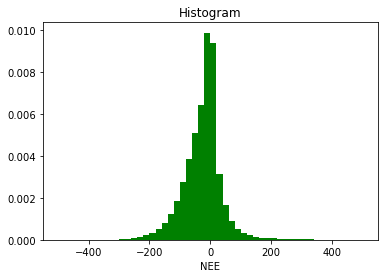

In [9]:
# compare histograms to fluxnet as in Baldocchi et al. 2018
# https://doi.org/10.1016/j.agrformet.2017.05.015

ds_ann.NEE[0,...].plot(range=(-500,500),bins=50, density=True, facecolor='g');
print(ds_ann.NEE[0,...].mean())
print(ds_ann.NEE[0,...].std())

mean GPP 838.2705269616886
detrended anomaly mean 0.05651550833344521
detrended anomaly sd  116.64549856202491
sd / mean 0.13915018458874667


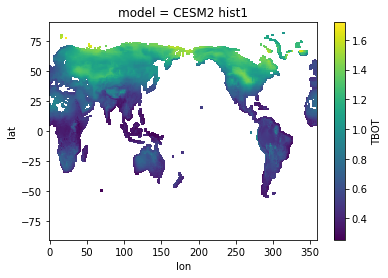

In [10]:
# Define function to detrend data
def dtrend(da_in, dim):
    # note: apply always moves core dimensions (time) to the end
    return xr.apply_ufunc(signal.detrend, da_in,
                       input_core_dims=[[dim]],
                       output_core_dims=[[dim]],
                       kwargs={'axis': -1})

# set up dataset to hold results
dt = xr.Dataset(coords={'model': [Model,Model1], 
                        'time': temp.time, 
                        'lat':ds.lat, 'lon':ds.lon})
jx_time = (temp['time.year']>1963)&(temp['time.year']<=2014)
jx_time1 = (temp['time.year']>1963)&(temp['time.year']<=2005)

# loop over data_vars
for i in range(len(v2)):         #loop through models
    dt[v2[i]] = xr.DataArray(np.empty(out_shape), dims=('model','time','lat','lon')) * np.nan

    dtemp  = dtrend(ds_ann[v2[i]][0,jx_time,:,:].load().fillna(0), 'time')
    dtemp1 = dtrend(ds_ann[v2[i]][1,jx_time1,:,:].load().fillna(0), 'time')

    dt[v2[i]][0,:,:,:] = dtemp.transpose('time','lat','lon') # transpose dimensions
    dt[v2[i]][1,0:len(years1),...] = dtemp1.transpose('time','lat','lon') # transpose dimensions 

# mask out missing values#dt[0,0,:,:].plot()
dt = dt.where(ds_ann.GPP>0)                   

# if we don't detrend data...
#dt = ds_ann.get('GPP') - ds_ann.get('GPP').mean(dim='time')
    
#for k in range(2):
#    simple = dt.plot(range=(-750,750),bins=50, density=True, facecolor='g',col='model',col_wrap=2);

#dt.GPP[1,...].plot(range=(-750,750),bins=50, density=True, facecolor='g');
print('mean GPP '+str(ds_ann.get('GPP').mean().values) ) # 1295 Baldocchi et al. 2018
print('detrended anomaly mean '+str(dt.GPP[0,...].mean().values) ) # 
print('detrended anomaly sd  ' +str(dt.GPP[0,...].std().values) ) # 230 in Baldocchi et al., 
print('sd / mean ' + str((dt.GPP[0,...].std() / ds_ann.get('GPP').mean()).values) )#17.8% of mean 
sd_ann = ds_ann.std(dim='time')
sd_dt = dt.std(dim='time')
sd_ann.TBOT[0,:,:].plot()

1543.2180017495393


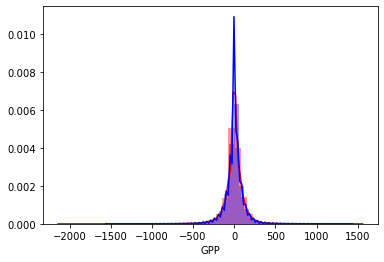

In [11]:
import seaborn as sns
#print(dt['model'])#to_dataframe())#.reset_index(dim))
ds_short = ds_ann[['GPP','NEE']]
#df = ds_short.to_dataframe()
#print(ds_short)
#cool, but kind of slow
#sns.pairplot(df.reset_index(), vars=ds_short.data_vars, hue="model")

# displot makes a histogram
df = dt.to_dataframe().dropna()
df0 = dt.isel(model=0).to_dataframe().dropna()
df1 = dt.isel(model=1).to_dataframe().dropna()

print(df0.GPP.max())
sns.distplot( df0.GPP, color='red', label=Model)
sns.distplot( df1.GPP, color='blue', label=Model1);
#sns.plt.legend()


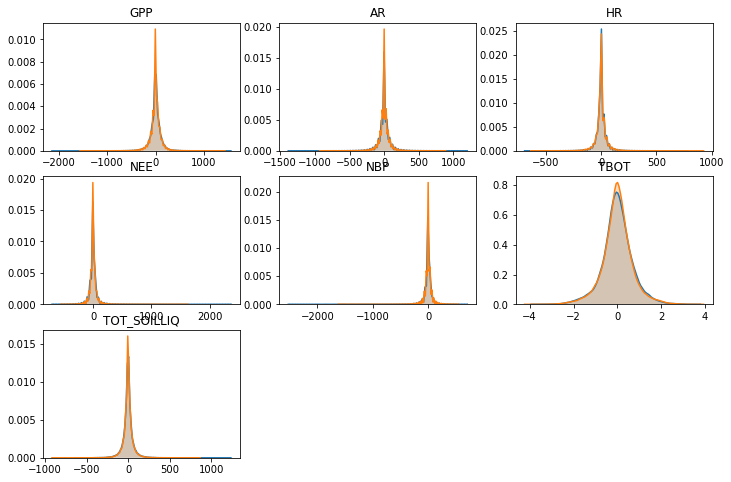

In [12]:
# joinplot as 2d histogram
#sns.jointplot(x=df0['TOT_SOILLIQ'], y=df0['GPP'], kind='kde', space=0)

plt.figure(figsize=[12,8])
r = 0
for j in range(len(v2)):
    plt.subplot(3,3,(j+1))
    sns.kdeplot(df0[v2[j]], shade=True, legend=False)
    sns.kdeplot(df1[v2[j]], shade=True, legend=False);
    plt.title(v2[j])
#grid.set(xlim=(14, titanic_data['Age'].max()), ylim=(0,0.06))
#grid.add_legend()


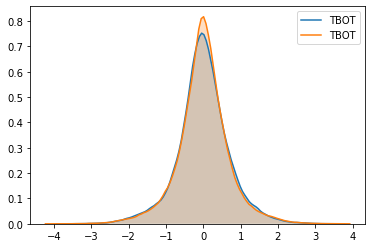

In [13]:
sns.kdeplot(df0['TBOT'], shade=True, clip=(-5,5))
sns.kdeplot(df1['TBOT'], shade=True, clip=(-5,5));


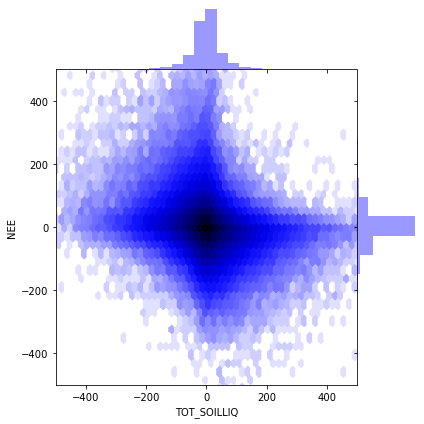

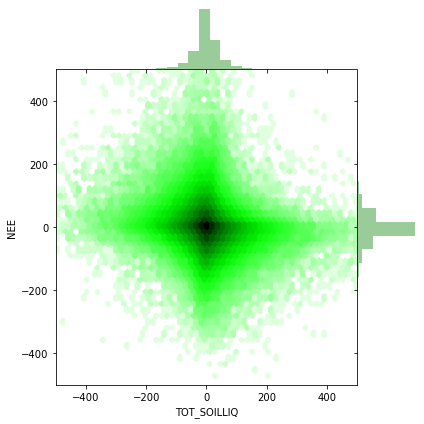

In [14]:
sns.jointplot(df0['TOT_SOILLIQ'], df0['NEE'],
              xlim=(-500,500),ylim=(-500,500),
              kind="hex", space=0, color="b",bins='log',gridsize=100);
sns.jointplot(df1['TOT_SOILLIQ'], df1['NEE'],
              xlim=(-500,500),ylim=(-500,500),
              kind="hex", space=0, color="g",bins='log',gridsize=100);

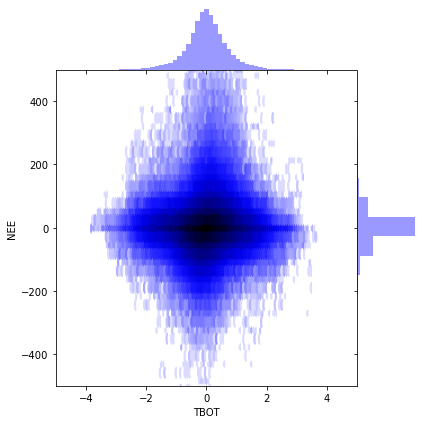

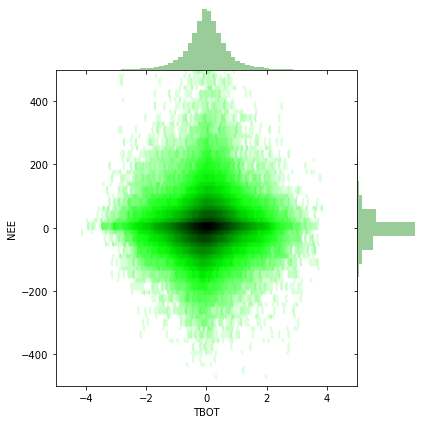

In [16]:
sns.jointplot(df0['TBOT'], df0['NEE'],
              xlim=(-5,5),ylim=(-500,500),
              kind="hex", space=0, color="b",bins='log',gridsize=100);
sns.jointplot(df1['TBOT'], df1['NEE'],
              xlim=(-5,5),ylim=(-500,500),
              kind="hex", space=0, color="g",bins='log',gridsize=100);

#### Set up regions to sum over

In [17]:
ix_area = xr.Dataset(coords={'model': [Model,Model1], 'lat':ds.lat, 'lon':ds.lon})
ix_area['land_area'] = xr.DataArray(np.empty((2,nlat,nlon)), dims=('model','lat','lon')) * np.nan
ix_area['land_area'][0,...] = ds.land_area
ix_area['land_area'][1,...] = ds1.land_area
print(ix_area)

ix_lat = [(ds['lat']>=-90)&(ds['lat']<=90),
          (ds['lat']>=-25)&(ds['lat']<=25),
          (ds['lat']>=25)&(ds['lat']<=50),
          (ds['lat']>=50)&(ds['lat']<=90),
          (ds['lat']>=-50)&(ds['lat']<=-25)]
regions = ['Global','Tropics','NH Mid','NH High', 'SH Mid']

<xarray.Dataset>
Dimensions:    (lat: 192, lon: 288, model: 2)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * model      (model) object 'CESM2 hist1' 'CLM5 GSWP3'
Data variables:
    land_area  (model, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan


In [18]:
# Create dataset with global sums
#  1e-15 for kg ->Tt & 1e-15 for g -> Pg

temp_glob = (ix_area['land_area'] * ds_ann).sum(dim=('lat','lon'))*1e-15
print(temp_glob.GPP[1,:])

<xarray.DataArray 'GPP' (time: 51)>
array([105.65966769, 103.85172666, 105.62362673, 107.21715455,
       107.7150595 , 105.27677095, 105.94277631, 107.32980676,
       105.42091849, 108.73448026, 111.22762853, 111.25870507,
       111.43651327, 111.85499027, 112.46238922, 111.38834491,
       109.89949249, 112.2295305 , 110.29208607, 108.84750573,
       110.86736016, 111.31137725, 112.86780052, 111.03673409,
       113.39125609, 115.43893991, 115.83182245, 115.15869756,
       112.8523524 , 114.92316294, 114.05480005, 115.18660707,
       114.62268847, 117.13412566, 115.49125928, 117.26893797,
       119.33478498, 118.19690718, 115.37636817, 116.208578  ,
       117.65856709, 118.32954253,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ])
Coordinates:
    model    <U10 'CLM5 GSWP3'
  * time     (time) object 1964-12-16 12:00:00 ... 2014-12-16 12:00:00


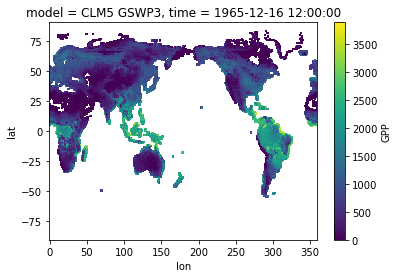

In [19]:
ds_ann.GPP[1,1,...].plot();

In [20]:
# loop through each variable, region:
# maybe quicker way to do this...?!
global_ann = xr.Dataset(coords={'model': [Model,Model1],
                              'region': regions,
                              'time': temp_glob.time })
out_shape = (2, len(regions), len(temp_glob.time ))

for i in range(len(v2)):
    global_ann[v2[i]] = xr.DataArray(np.empty(out_shape), dims=('model','region','time')) * np.nan
    for j in range(len(regions)):

        if var[i] == 'TBOT':
            # need to weight differently based on region size
            # also want to avoid zeros summed for missing years
            wgt = ix_area.land_area[:,ix_lat[j],:] / ix_area.land_area[:,ix_lat[j],:].sum(dim=('lat','lon'))
            global_ann[var[i]][:,j,:]= (wgt * ds_ann.TBOT[:,:,ix_lat[j],:]).sum(dim=('lat','lon'))

        else:
            global_ann[v2[i]][:,j,:] = (ix_area['land_area'][:,ix_lat[j],:]* ds_ann[v2[i]][:,:,ix_lat[j],:]).sum(dim=('lat','lon'))*1e-15

#print(global_ann)            
global_ann = global_ann.where(global_ann.GPP>0)
print(global_ann.TBOT.isel(time = slice(len(years1),None)) )
print()
#global_ann.GPP[1,...].isel(time = slice(len(years1),None)) = global_ann.GPP[1,...].isel(time = slice(len(years1),None)) * np.nan
#global_ann.TBOT[1,0,:].plot();
print(global_ann.GPP[1,1,:])

<xarray.DataArray 'TBOT' (model: 2, region: 5, time: 9)>
array([[[15.2764113 , 15.61509215, 15.24413998, 14.91530287,
         15.24334489, 15.55505852, 15.7317779 , 15.6224172 ,
         15.43232158],
        [25.062305  , 25.51079883, 24.81395806, 24.91288478,
         25.13650219, 25.14734985, 25.64302164, 25.58541906,
         24.9065566 ],
        [12.9569747 , 13.32115812, 13.19414047, 12.23066783,
         12.80922082, 13.1887972 , 13.14975111, 13.06112455,
         13.39246427],
        [-0.9125525 , -0.68617376, -0.89843867, -1.31615797,
         -1.01161977, -0.07620893, -0.26484542, -0.53601518,
         -0.4038535 ],
        [17.27085182, 17.20553689, 17.19733494, 17.37348227,
         17.30571508, 17.21299875, 17.56541177, 17.53611537,
         16.975205  ]],

       [[        nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,
                 nan],
        [        nan,         nan,         nan,         nan,
          

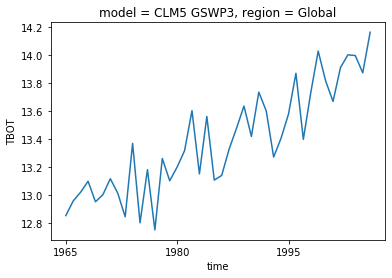

In [21]:
global_ann.TBOT[1,0,:].plot();

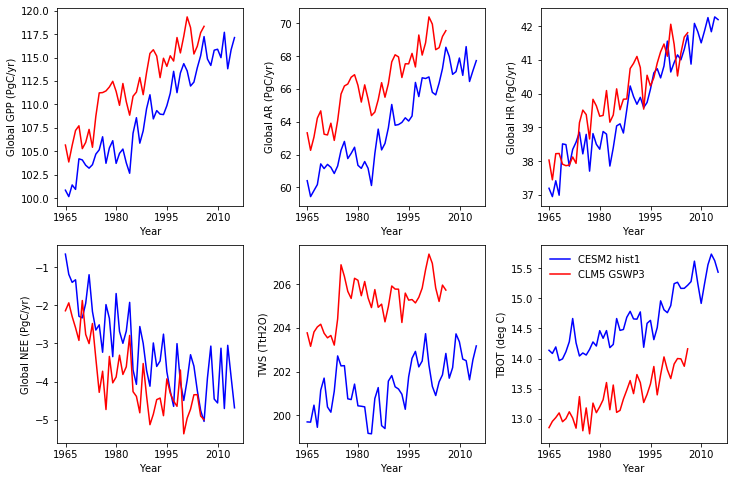

In [22]:
# sanity check
plt.figure(figsize=[12,8])
col = ['b','r']
r = 0
for j in range(4):
    plt.subplot(2,3,(j+1))
    for i in range(2):
        plt.plot(global_ann.time,global_ann[var[j]][i,r,:],color=col[i])
    plt.xlabel('Year')
    plt.ylabel(regions[r]+' '+var[j]+' (PgC/yr)')

plt.subplot(235)
for i in range(2):
    plt.plot(global_ann.time,global_ann.TOT_SOILLIQ[i,r,:],color=col[i])
plt.xlabel('Year')
plt.ylabel('TWS (TtH2O)')

plt.subplot(236)
for i in range(2):
    plt.plot(global_ann.time,global_ann.TBOT[i,r,:],color=col[i])
plt.xlabel('Year')
plt.ylabel('TBOT (deg C)')
plt.legend((Model, Model1),loc=2,frameon=False)
plt.subplots_adjust(wspace=0.3);

## Detrend data and fit linear model

In [23]:
global_ann_dt = xr.Dataset(coords={'model': [Model,Model1], 'region': regions, 'time': temp.time})
for i in range(len(v2)):
    global_ann_dt[v2[i]] = xr.DataArray(np.empty(out_shape), dims=('model','region','time')) * np.nan
    for j in range(len(regions)):
        global_ann_dt[v2[i]][0,j,:] = signal.detrend(global_ann[v2[i]][0,j,:])
        global_ann_dt[v2[i]][1,j,0:len(years1)] = signal.detrend(global_ann[v2[i]][1,j,0:len(years1)])

In [24]:
print(global_ann_dt['time.year'].isel(time=slice(16,None)))
global_sd = global_ann_dt.isel(time=slice(16,None)).std('time') 
print(global_sd)

<xarray.DataArray 'year' (time: 35)>
array([1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990,
       1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014])
Coordinates:
  * time     (time) object 1980-12-16 12:00:00 ... 2014-12-16 12:00:00
<xarray.Dataset>
Dimensions:      (model: 2, region: 5)
Coordinates:
  * model        (model) object 'CESM2 hist1' 'CLM5 GSWP3'
  * region       (region) object 'Global' 'Tropics' 'NH Mid' 'NH High' 'SH Mid'
Data variables:
    GPP          (model, region) float64 1.537 1.181 0.4609 ... 0.499 0.2341
    AR           (model, region) float64 0.976 0.723 0.2853 ... 0.2874 0.1278
    HR           (model, region) float64 0.3814 0.2855 0.1543 ... 0.2261 0.08625
    NEE          (model, region) float64 0.6624 0.5358 0.1937 ... 0.1663 0.08776
    NBP          (model, region) float64 0.6623 0.5655 0.1843 ... 0.1503 0.08143
    TBOT         (

In [25]:
print(global_ann_dt)

<xarray.Dataset>
Dimensions:      (model: 2, region: 5, time: 51)
Coordinates:
  * model        (model) object 'CESM2 hist1' 'CLM5 GSWP3'
  * region       (region) object 'Global' 'Tropics' 'NH Mid' 'NH High' 'SH Mid'
  * time         (time) object 1964-12-16 12:00:00 ... 2014-12-16 12:00:00
Data variables:
    GPP          (model, region, time) float64 0.1141 -0.901 0.01506 ... nan nan
    AR           (model, region, time) float64 0.7575 -0.383 -0.1847 ... nan nan
    HR           (model, region, time) float64 -0.04175 -0.3888 ... nan nan
    NEE          (model, region, time) float64 1.048 0.5745 0.4226 ... nan nan
    NBP          (model, region, time) float64 -0.9971 -0.5029 ... nan nan
    TBOT         (model, region, time) float64 0.2276 0.145 0.2228 ... nan nan
    TOT_SOILLIQ  (model, region, time) float64 -0.4621 -0.5229 ... nan nan


## Plot
Loop through C fluxes w/ moisture and temperature anomalies


/glade/u/home/wwieder/miniconda3/envs/python-tutorial/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.
/glade/u/home/wwieder/miniconda3/envs/python-tutorial/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.
/glade/u/home/wwiede

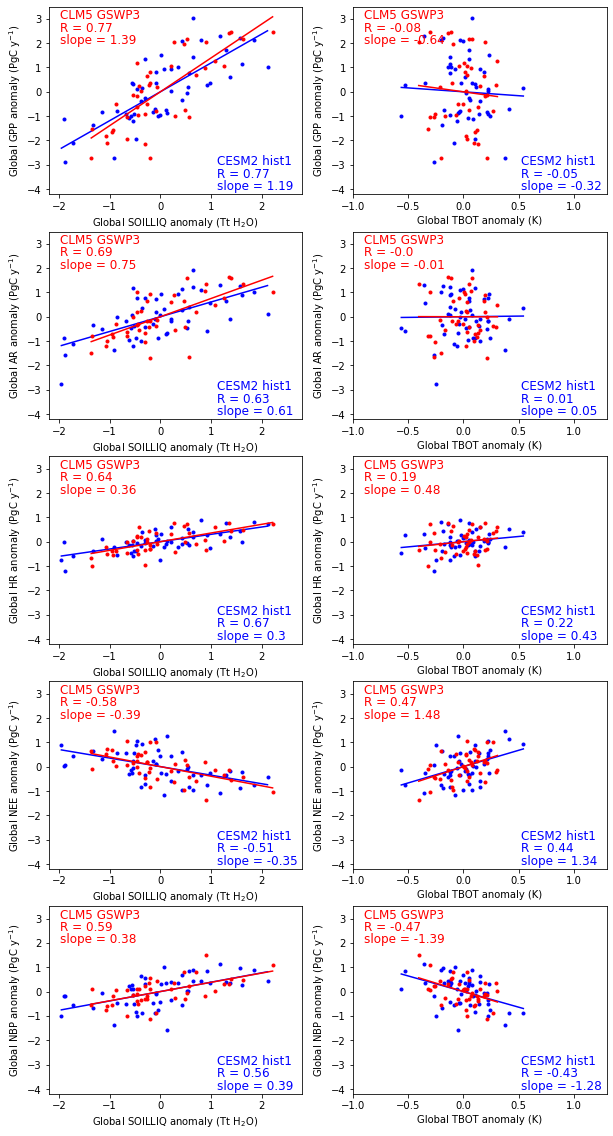

In [31]:
nyrs = [len(years),len(years1)]
r = 0          #region 0 = global, 1 = tropics

fig = plt.figure(figsize=[10,20])
k = 0
for j in range(5):
    for h in range(2):
        k = k+1
        for i in range(2):
            plt.subplot(5,2,k)
            if h == 0:
                x  = global_ann_dt.TOT_SOILLIQ[i,r,0:nyrs[i]].values
                xlim=[-2.2,2.8]
            else:
                x  = global_ann_dt.TBOT[i,r,0:nyrs[i]].values
                xlim=[-1,1.3]

            y  = global_ann_dt[v2[j]][i,r,0:nyrs[i]].values
            model = LinearRegression().fit(x.reshape((-1, 1)), y)
            R = np.round(stats.pearsonr(x,y)[0],2)
            slope = np.round(model.coef_,2)[0]

            xRange = np.array([x.min(),x.max()]).reshape(-1, 1)
            yPred = model.predict(xRange)

            plt.plot(x, y,'.',color=col[i])
            plt.plot(xRange,yPred, color=col[i])
            plt.ylim(-4.2,3.5)
            plt.xlim(xlim)

            if i == 1:
                plt.text(xlim[0]*0.9,3,Model1,fontsize=12, color='r')
                plt.text(xlim[0]*0.9,2.5,'R = '+str(R),fontsize=12, color='r')
                plt.text(xlim[0]*0.9,2.0,'slope = '+str(slope),fontsize=12, color='r')
                #plt.text(-2.,1.5,'1964-2005',fontsize=12, color='r')

            if i == 0: 
                plt.text(xlim[1]*0.4,-3.0,Model,fontsize=12, color='b')
                plt.text(xlim[1]*0.4,-3.5,'R = '+str(R),fontsize=12, color='b')
                plt.text(xlim[1]*0.4,-4.0,'slope = '+str(slope),fontsize=12, color='b')
                #plt.text(xlim[1]*0.4,-4.0,'1964-2014',fontsize=12, color='b')

        if h == 0: 
            plt.xlabel(regions[r]+' SOILLIQ anomaly (Tt $\mathregular{H_2O}$)')
        else:
            plt.xlabel(regions[r]+' TBOT anomaly (K)')
            
        plt.ylabel(regions[r]+' '+v2[j]+' anomaly (PgC $\mathregular{y^{-1}}$)');
#plt.title(Model);

In [20]:
print(model.score)

<bound method RegressorMixin.score of LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)>


The slope of the line is similar to gamma_iav from Gretchen's 2018 paper (PgC y^-1 K^-1)?

How similar are global and tropical anomalies?

In [27]:
print(v2)

['GPP', 'AR', 'HR', 'NEE', 'NBP', 'TBOT', 'TOT_SOILLIQ']


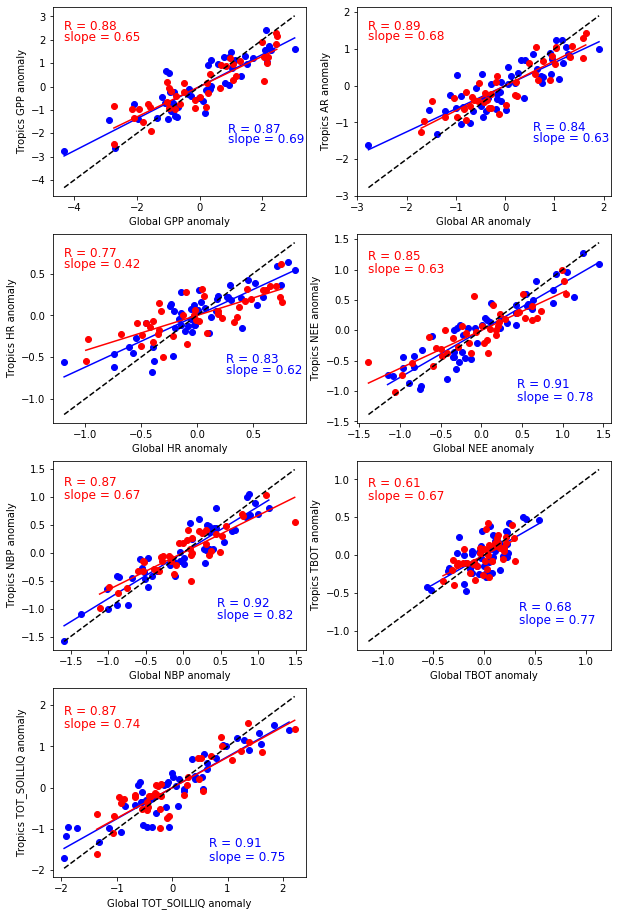

In [28]:
fig = plt.figure(figsize=[10,16])
k = 0

for j in range(len(v2)):
    k = k+1
    plt.subplot(4,2,k)
    x_range = [global_ann_dt[v2[j]].min(),global_ann_dt[v2[j]].max()]
    for i in range(2): #for each model
        y  = global_ann_dt[v2[j]][i,1,0:nyrs[i]].values  # tropics only
        x  = global_ann_dt[v2[j]][i,0,0:nyrs[i]].values  # global
        model = LinearRegression().fit(x.reshape((-1, 1)), y)
        R = np.round(stats.pearsonr(x,y)[0],2)
        slope = np.round(model.coef_,2)[0]

        xlim=[x.min(),x.max()]
        xRange = np.array(xlim).reshape(-1, 1)
        yPred = model.predict(xRange)

        plt.plot(x, y,'o',color=col[i])
        plt.plot(xRange,yPred, color=col[i])
        
        if i == 1:
            plt.text(x_range[0],x_range[1]*0.8,'R = '+str(R),fontsize=12, color='r')
            plt.text(x_range[0],x_range[1]*0.65,'slope = '+str(slope),fontsize=12, color='r')

        if i == 0: 
            plt.text(x_range[1]*0.3,x_range[1]*-0.65,'R = '+str(R),fontsize=12, color='b')
            plt.text(x_range[1]*0.3,x_range[1]*-0.8,'slope = '+str(slope),fontsize=12, color='b')

            
    plt.ylabel(regions[1]+' '+v2[j]+' anomaly')
    plt.xlabel(regions[0]+' '+v2[j]+' anomaly')
        
    plt.plot(x_range, x_range, 'k--')



Slope says what fraction of global anomalies are expliained by tripics?

## TWS & TBOT correlation

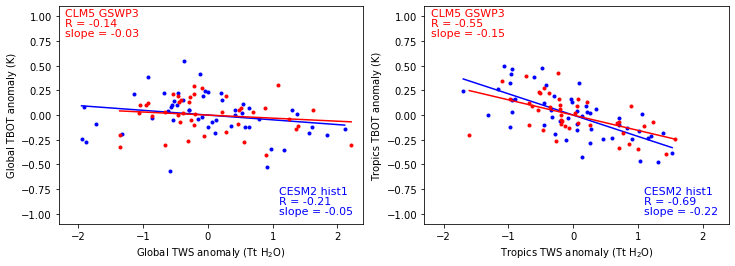

In [29]:
#SOILLIQ ~ TBOT
r = 0
fig = plt.figure(figsize=[12,4])
for r in range(2):
    plt.subplot(1,2,(r+1))
    for i in range(2):
        x  = global_ann_dt.TOT_SOILLIQ[i,r,0:nyrs[i]].values
        y  = global_ann_dt.TBOT[i,r,0:nyrs[i]].values
        model = LinearRegression().fit(x.reshape((-1, 1)), y)
        R = np.round(stats.pearsonr(x,y)[0],2)
        slope = np.round(model.coef_,2)[0]

        xRange = np.array([x.min(),x.max()]).reshape(-1, 1)
        yPred = model.predict(xRange)

        plt.plot(x, y,'.',color=col[i])
        plt.plot(xRange,yPred, color=col[i])

        plt.xlim(-2.3,2.4)
        plt.ylim(-1.1,1.1)
        if i == 1:
            plt.text(-2.2,1.0,Model1,fontsize=11, color='r')
            plt.text(-2.2,0.9,'R = '+str(R),fontsize=11, color='r')
            plt.text(-2.2,0.8,'slope = '+str(slope),fontsize=11, color='r')
            #plt.text(-2.,1.5,'1964-2005',fontsize=12, color='r')

        if i == 0: 
            plt.text(1.1,-0.8,Model,fontsize=11, color='b')
            plt.text(1.1,-0.9,'R = '+str(R),fontsize=11, color='b')
            plt.text(1.1,-1.0,'slope = '+str(slope),fontsize=11, color='b')

    plt.xlabel(regions[r]+' TWS anomaly (Tt $\mathregular{H_2O}$)')
    plt.ylabel(regions[r]+' TBOT anomaly (K)');
    #plt.title(Model);

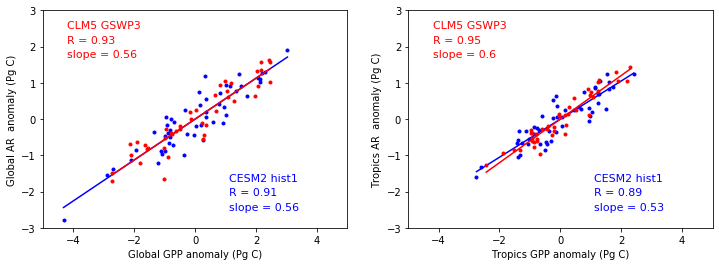

In [37]:
#SOILLIQ ~ TBOT
r = 0
fig = plt.figure(figsize=[12,4])
for r in range(2):
    plt.subplot(1,2,(r+1))
    for i in range(2):
        x  = global_ann_dt.GPP[i,r,0:nyrs[i]].values
        y  = global_ann_dt.AR[i,r,0:nyrs[i]].values
        model = LinearRegression().fit(x.reshape((-1, 1)), y)
        R = np.round(stats.pearsonr(x,y)[0],2)
        slope = np.round(model.coef_,2)[0]

        xRange = np.array([x.min(),x.max()]).reshape(-1, 1)
        yPred = model.predict(xRange)

        plt.plot(x, y,'.',color=col[i])
        plt.plot(xRange,yPred, color=col[i])

        plt.xlim(-5,5)
        plt.ylim(-3,3)
        if i == 1:
            plt.text(-4.2,2.5,Model1,fontsize=11, color='r')
            plt.text(-4.2,2.1,'R = '+str(R),fontsize=11, color='r')
            plt.text(-4.2,1.7,'slope = '+str(slope),fontsize=11, color='r')
            #plt.text(-2.,1.5,'1964-2005',fontsize=12, color='r')

        if i == 0: 
            plt.text(1.1,-1.7,Model,fontsize=11, color='b')
            plt.text(1.1,-2.1,'R = '+str(R),fontsize=11, color='b')
            plt.text(1.1,-2.5,'slope = '+str(slope),fontsize=11, color='b')

    plt.xlabel(regions[r]+' GPP anomaly (Pg C)')
    plt.ylabel(regions[r]+' AR  anomaly (Pg C)');
    #plt.title(Model);